In [16]:
%matplotlib widget
from ipywidgets import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider
import control as ct

#### Constants
# Measured from the arduino
dt_micros = 250  # microseconds per loop
dt = dt_micros / 10**6  # seconds
t_start = 0  # seconds
t_end = 25.05  # seconds
num_points = int(np.ceil((t_end - t_start) / dt))
t_list = np.linspace(t_start, t_end, num_points)


MIN_DIST = 0.000001  # m
MAX_DIST = 0.15  # m

R = 28.5 # ohms
L = 0.051337  # H

m = 8.5443/1000  # kg
g = 9.8  # m/s^2

x_0 = 0.015 # m
pwm_0 = 190
# a - b * (PWM**2) / X**2
C_1 = -0.008052525002733787 # a
C_2 = -4.284764699038538e-10 # b


     -0.0007236
--------------------
0.008544 s^2 - 9.166

K_P: 5000000.0, K_I: 1.0, K_D: 200000.0


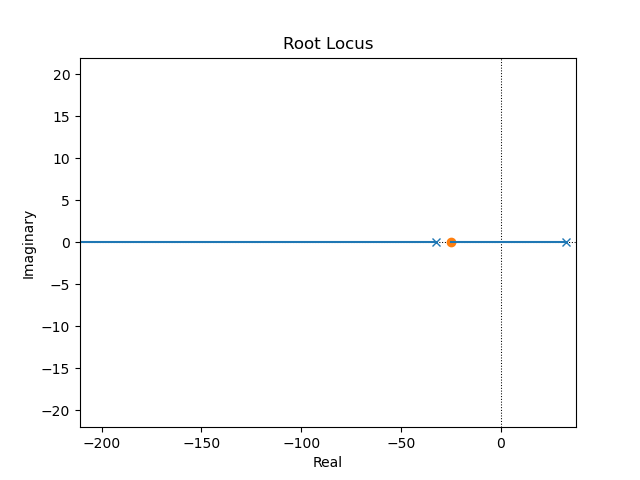

In [30]:
K = 100000
K_P = 50.0 * K
K_I = 1.0
K_D = 2.0 * K

G_1 = ct.tf([(2.0*C_2*pwm_0)/(x_0**2)], [m, 0, (2.0*C_2*pwm_0**2)/(x_0**3)])
G_2 = ct.tf([1], [L, R])
G = G_1#*G_2
C_PD = ct.tf([K_D, K_P], [1])
C_PID = ct.tf([K_D, K_P, K_I], [1, 0])
beta = 0.1
tau = 20
C_LEAD = (1/beta)*ct.tf([1, 1/tau], [1, 1/(beta*tau)])

C = C_PD # Choose the controller

plt.figure()
ct.root_locus(-C*G, grid=False);
print(G)
print(f"K_P: {K_P}, K_I: {K_I}, K_D: {K_D}")

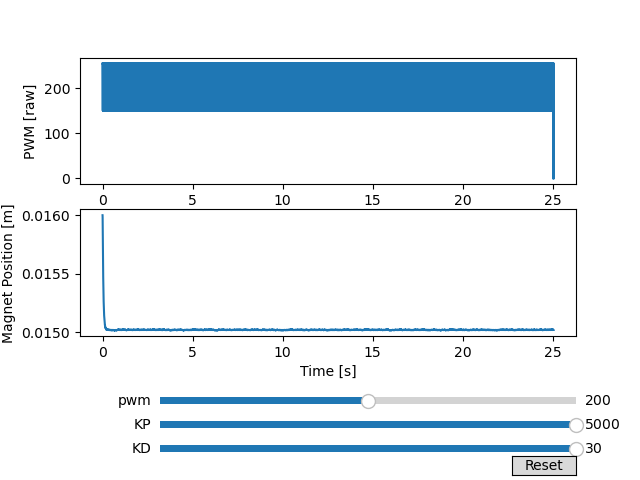

In [31]:

def simulate(K_P, K_D, sigma=0.0001, pwm_setpoint = 200.0):
    global x_0, pwm_0
    pwm = np.zeros(num_points)
    x = np.zeros(num_points)
    x[0] = x_0 + 0.001
    x[1] = x_0 + 0.001
    pwm[0] = pwm_0
    e_prev = 0

    for t in range(0, num_points - 2):
        disturbance = np.random.normal(0, sigma)
        e = x[t] - x_0
        pwm[t] = np.clip(K_P * e + K_D * (e - e_prev) / dt + pwm_0, 150, 255)
        # # v_i = K_P * e + K_D * (e - e_prev) / dt + v_0
        # i[t + 1] = i[t] + dt * ((12*(pwm-150)/(255-150)) - R * i[t]) / L
        # x[t + 2] = (
        #         2 * x[t + 1]
        #         - x[t]
        #         + ((dt**2) / m)
        #         * (
        #             -(x[t] * 2 * C_2 * pwm_0**2) / (x_0**3) + 
        #             (pwm[t] * pwm_0 * 2 * C_2) / (x_0**2)
        #         )
        # )
        x[t + 2] = (
                2 * x[t + 1]
                - x[t]
                + ((dt**2) / (m))
                * (m*g - C_1 + (C_2 * pwm[t]**2) / x[t]**2)
        )
        x[t + 2] = np.clip(x[t + 2] , MIN_DIST, MAX_DIST)
        e_prev = e
    pwm[-1] = pwm[-2]
    return pwm, x


pwm, x = simulate(K_P, K_D)

fig, axs = plt.subplots(2)

(line_pwm,) = axs[0].plot(t_list, pwm, label="PWM")
axs[0].set(xlabel="Time [s]", ylabel="PWM [raw]")

(line_x,) = axs[1].plot(t_list, x, label=f"Model")
axs[1].set(xlabel="Time [s]", ylabel="Magnet Position [m]")

fig.subplots_adjust(bottom=0.3)

axpwm = fig.add_axes([0.25, 0.15, 0.65, 0.03])
pwm_slider = Slider(
    ax=axpwm,
    label="pwm",
    valmin=180,
    valmax=220,
    valinit=200,
    valstep=1,
)

axkp = fig.add_axes([0.25, 0.1, 0.65, 0.03])
kp_slider = Slider(
    ax=axkp,
    label="KP",
    valmin=0,
    valmax=5000,
    valinit=K_P,
    valstep=100,
)
axkd = fig.add_axes([0.25, 0.05, 0.65, 0.03])
kd_slider = Slider(
    ax=axkd,
    label="KD",
    valmin=0,
    valmax=30,
    valinit=K_D,
    valstep=0.5,
)


def update(val):
    pwm, x = simulate(kp_slider.val, kd_slider.val, pwm_setpoint=pwm_slider.val)
    line_pwm.set_ydata(pwm)
    line_x.set_ydata(x)
    fig.canvas.draw_idle()


pwm_slider.on_changed(update)
kp_slider.on_changed(update)
kd_slider.on_changed(update)
resetax = fig.add_axes([0.8, 0.01, 0.1, 0.04])
button = Button(resetax, "Reset", hovercolor="0.975")


def reset(event):
    kp_slider.set_val(K_P)
    kd_slider.set_val(K_D)


button.on_clicked(reset)
plt.show()